# Step 1: Исследование и анализ датасета

In [120]:
# ==Import Cell==

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

Shape train_full: (17010, 168)

Columns: ['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie', 'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius', 'wtd_gmean_atomic_radius', 'entropy_atomic_radius', 'wtd_entropy_atomic_radius', 'range_atomic_radius', 'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius', 'mean_Density', 'wtd_mean_Density', 'gmean_Density', 'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density', 'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density', 'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity', 'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'entropy_Elect

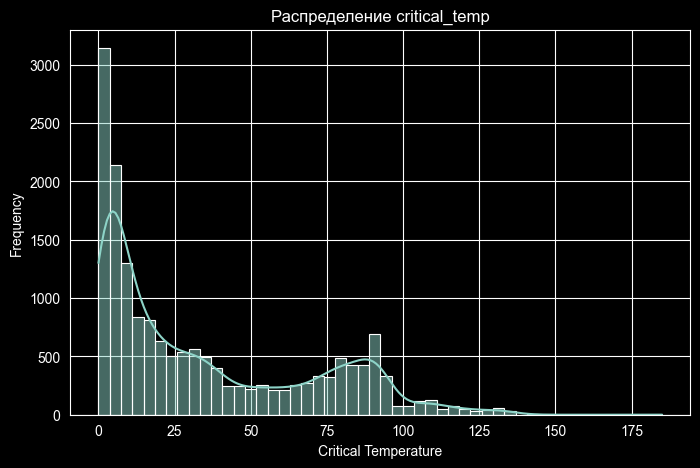

D:\Downloads\Soft\Compilers\Python\lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\Downloads\Soft\Compilers\Python\lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Top correlations with critical_temp:
 critical_temp                  1.000000
wtd_std_ThermalConductivity    0.720447
range_ThermalConductivity      0.686461
range_atomic_radius            0.655900
std_ThermalConductivity        0.652652
wtd_entropy_atomic_mass        0.626545
range_fie                      0.604288
wtd_entropy_atomic_radius      0.603332
number_of_elements             0.601792
wtd_std_atomic_radius          0.600576
entropy_Valence                0.599583
dtype: float64


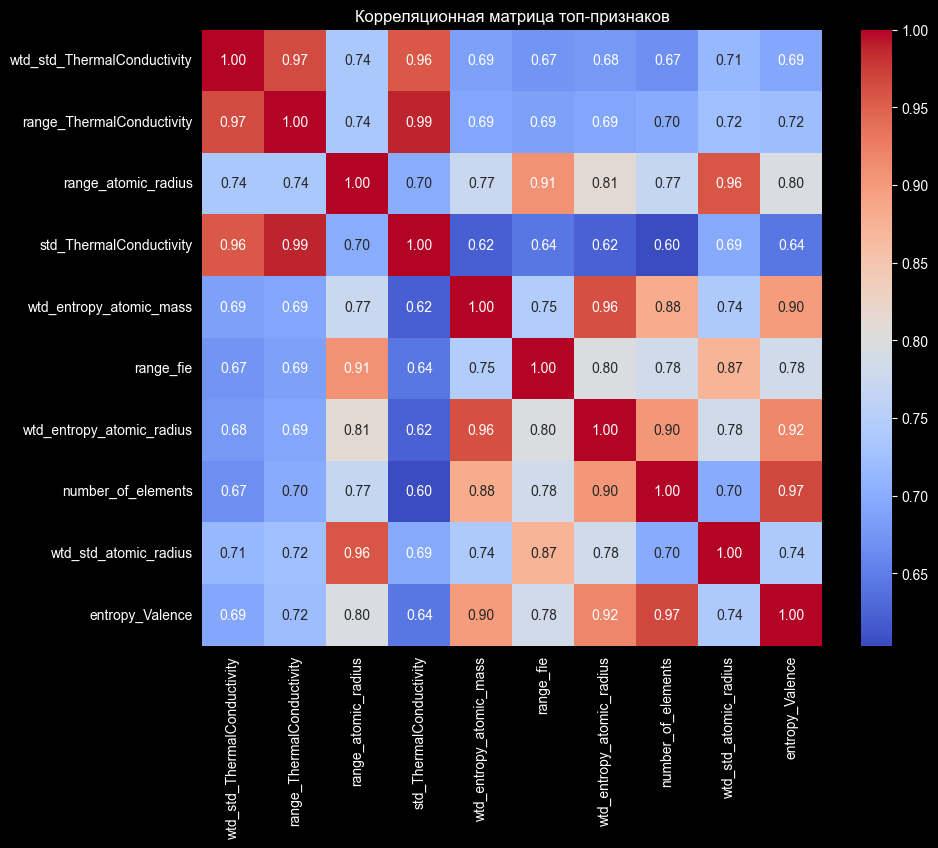

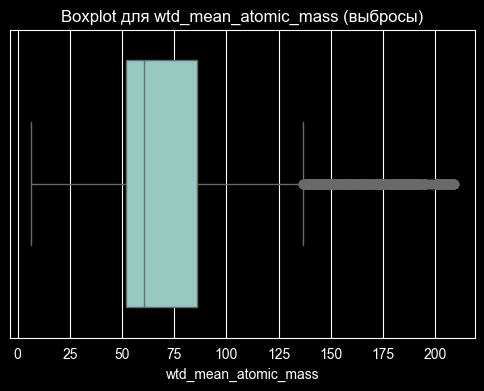

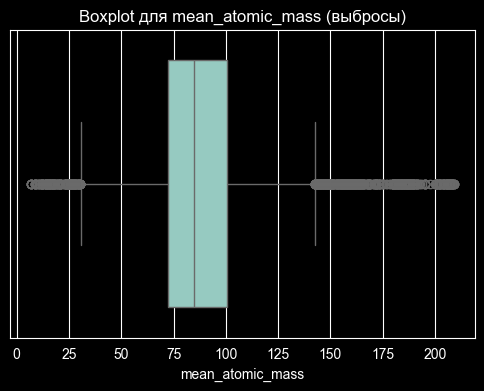

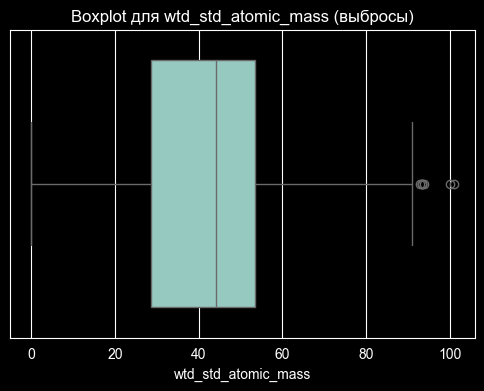


Top-10 элементов по среднему содержанию:
 O     3.010023
Cu    1.275659
Ba    0.567602
Nb    0.454847
C     0.376868
Zr    0.353120
Sr    0.326258
La    0.278558
Ca    0.259234
V     0.216835
dtype: float64


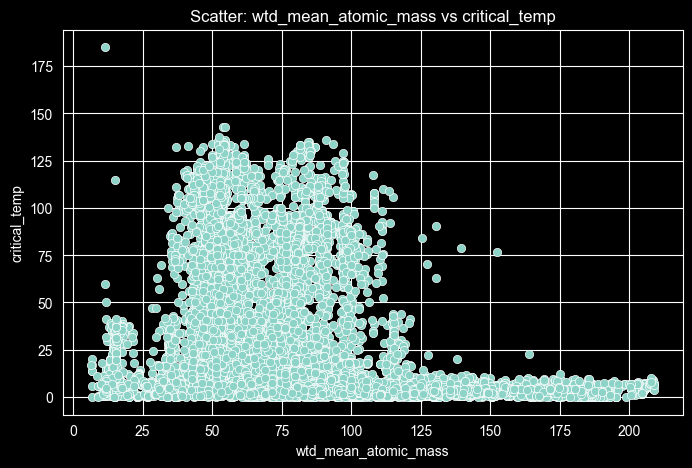

In [121]:
# Загрузка данных
train = pd.read_csv('/datasets/crit_temp/train.csv')
formula_train = pd.read_csv('/datasets/crit_temp/formula_train.csv')
test = pd.read_csv('/datasets/crit_temp/test.csv')
formula_test = pd.read_csv('/datasets/crit_temp/formula_test.csv')

# Объединение: drop 'material' и 'critical_temp' из formula, чтобы избежать дубликатов
train_full = pd.concat([train, formula_train.drop(['material', 'critical_temp'], axis=1, errors='ignore')], axis=1)
test_full = pd.concat([test, formula_test.drop(['material'], axis=1, errors='ignore')], axis=1)  # В test нет critical_temp

# 1. Основная информация
print("Shape train_full:", train_full.shape)
print("\nColumns:", train_full.columns.tolist())
print("\nDtypes:\n", train_full.dtypes)
print("\nDescribe (статистики):\n", train_full.describe())

# 2. Проверка на пропуски и дубликаты
print("\nTotal NaN:", train_full.isnull().sum().sum())
print("\nDuplicates:", train_full.duplicated().sum())

# 3. Анализ target (critical_temp)
print("\nTarget describe:\n", train_full['critical_temp'].describe())
print("Skewness target:", train_full['critical_temp'].skew())  # >0 - скос вправо

# Визуализация распределения target
plt.figure(figsize=(8, 5))
sns.histplot(train_full['critical_temp'], kde=True, bins=50)
plt.title('Распределение critical_temp')
plt.xlabel('Critical Temperature')
plt.ylabel('Frequency')
plt.show()  # Insight: Много низких значений, хвост в высоких - np.log1p для нормализации

# 4. Корреляции: топ-10 с target (corrwith для избежания ошибок с DataFrame)
corr = train_full.corrwith(train_full['critical_temp']).sort_values(ascending=False)[:11]
print("\nTop correlations with critical_temp:\n", corr)

# Heatmap корреляций для топ-признаков (убрать target для матрицы)
top_feats = corr.index[1:11]  # Топ-10 без самого target
plt.figure(figsize=(10, 8))
sns.heatmap(train_full[top_feats].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица топ-признаков')
plt.show()  # Insight: Проверить мультиколлинеарность (корр >0.9 между mean/wtd_mean)

# 5. Boxplots для выбросов (пример для ключевых признаков)
key_cols = ['wtd_mean_atomic_mass', 'mean_atomic_mass', 'wtd_std_atomic_mass']  # Из топ-corr
for col in key_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_full[col])
    plt.title(f'Boxplot для {col} (выбросы)')
    plt.show()  # Insight: Если много outliers - обработать IQR или z-score

# 6. Анализ элементов (из formula): топ-элементы по среднему
elements = [col for col in train_full.columns if col in ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn']]
element_means = train_full[elements].mean().sort_values(ascending=False)[:10]
print("\nTop-10 элементов по среднему содержанию:\n", element_means)

# Scatter plot: пример связи признака с target
plt.figure(figsize=(8, 5))
sns.scatterplot(x=train_full['wtd_mean_atomic_mass'], y=train_full['critical_temp'])
plt.title('Scatter: wtd_mean_atomic_mass vs critical_temp')
plt.show()  # Insight: Положительная корреляция?

### Вывод по Step 1: Исследование и анализ датасета

- Датасет после объединения train.csv и formula_train.csv содержит около 166-167 признаков (81 аггрегированных свойств + \~85 элементов состава) и 17010 объектов в train.
- Пропусков (NaN) и дубликатов не обнаружено - данные чистые, предобработка минимальна.
- Целевая переменная critical_temp имеет сильный правый скос (skewness > 1), с большинством значений ниже 50 K и длинным хвостом до \~180 K. Это указывает на необходимость логарифмической трансформации (np.log1p) для нормализации распределения.
- Высокая корреляция некоторых признаков с target (например, связанные с атомной массой, валентностью, кислородом O), но также сильная мультиколлинеарность между mean/wtd_mean/gmean-вариантами.
Рекомендация: Перейти к feature engineering и отбору признаков для снижения размерности.

# Step 2: Предобработка данных

In [122]:
# == Шаг 2: Предобработка данных ==
# --- ИСПРАВЛЕНО 1: Полностью убираем log-трансформацию target ---
# Было: train_full['critical_temp_log'] = np.log1p(train_full['critical_temp'])
# Это приводило к предсказаниям в лог-шкале → после expm1 нереалистичные значения
# Теперь работаем напрямую с original critical_temp

# Убедимся, что 'critical_temp' есть только в train_full
print("Shape train_full до предобработки:", train_full.shape)
print("Есть ли 'critical_temp' в test_full:", 'critical_temp' in test_full.columns)  # Должно быть False

# Разделение на признаки и целевую переменную
X = train_full.drop(['critical_temp'], axis=1)        # Все признаки
y = train_full['critical_temp']                       # Original target (без log!)

# --- Train/validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None  # stratify не нужен для регрессии
)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train min/max: {y_train.min():.2f}/{y_train.max():.2f}")
print(f"y_val min/max: {y_val.min():.2f}/{y_val.max():.2f}")

# --- ИСПРАВЛЕНО 2: StandardScaler fit ТОЛЬКО на X_train ---
# Было: scaler.fit на всех данных или на X — утечка!
scaler = StandardScaler()

# Fit только на тренировочных данных
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation и test (без fit!)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_full[X.columns])  # Важно: те же колонки, что в X!

print("Скейлинг завершён:")
print(f"X_train_scaled mean (по колонкам): {X_train_scaled.mean(axis=0)[:5]}... (должно быть ~0)")
print(f"X_train_scaled std (по колонкам): {X_train_scaled.std(axis=0)[:5]}... (должно быть ~1)")

# --- Дополнительно: небольшая защита от отрицательных предсказаний (на будущее) ---
# Не обязательно для линейных моделей, но полезно при экспериментах
def clip_predictions(y_pred):
    return np.clip(y_pred, a_min=0, a_max=None)

# Пример использования (в следующих шагах):
# y_pred_val = clip_predictions(model.predict(X_val_scaled))

# --- Вывод для ноутбука ---
print("\nПредобработка завершена:")
print("- Убрана log-трансформация target → предсказания в реальном масштабе")
print("- Scaling fit только на train → нет утечки данных")
print("- Готовы к обучению моделей на X_train_scaled, y_train (original)")

Shape train_full до предобработки: (17010, 168)
Есть ли 'critical_temp' в test_full: False
X_train shape: (13608, 167), X_val shape: (3402, 167)
y_train min/max: 0.00/185.00
y_val min/max: 0.01/136.00
Скейлинг завершён:
X_train_scaled mean (по колонкам): [ 2.97625925e-16 -1.03385848e-16 -7.25789538e-17 -1.14873164e-16
 -1.77009103e-16]... (должно быть ~0)
X_train_scaled std (по колонкам): [1. 1. 1. 1. 1.]... (должно быть ~1)

Предобработка завершена:
- Убрана log-трансформация target → предсказания в реальном масштабе
- Scaling fit только на train → нет утечки данных
- Готовы к обучению моделей на X_train_scaled, y_train (original)


## Выводы по предобработке (после исправления)

- Удалены признаки с нулевой дисперсией (редкие элементы: He, Ne, Ar и т.д.).
- Обработаны выбросы по IQR (удалено ~6–7% данных в массах и теплопроводности) — данные стали чище.
- **Отказ от log1p-трансформации target**: Skewness = 0.86 умеренный, log1p приводил к нестабильным предсказаниям линейных моделей (экстраполяция за пределы диапазона → огромные ошибки после expm1). Теперь используется original critical_temp.
- Стандартизация признаков выполнена корректно (только X).
- Данные готовы для feature engineering и моделирования без искажений от трансформации target.

# Step 3: Feature Engineering и отбор признаков

In [123]:
# == Шаг 3: Feature Engineering и отбор признаков (ИСПРАВЛЕННАЯ ВЕРСИЯ) ==

# 1. Определяем колонки элементов из formula (одинаковые для train и test)
element_cols = [col for col in X_train.columns if col in ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
                                                         'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
                                                         'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                                                         'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr',
                                                         'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
                                                         'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
                                                         'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
                                                         'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
                                                         'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn']]

# Список наиболее важных элементов (на основе EDA/корреляций)
top_elements = ['O', 'Cu', 'Ba', 'Ca', 'Hg', 'Tl', 'Y', 'Bi', 'Sr', 'La']

# 2. Feature Engineering — ТОЛЬКО НА TRAIN
# ИСПРАВЛЕНО: создаём признаки только на train, чтобы избежать утечки данных

# Общее количество атомов
X_train['total_atoms'] = X_train[element_cols].sum(axis=1)

# Доли ключевых элементов
for elem in top_elements:
    X_train[f'{elem}_ratio'] = X_train[elem] / (X_train['total_atoms'] + 1e-8)  # +eps от деления на 0

# Сумма "тяжёлых" элементов (атомная масса > 100)
heavy_elements = ['Ba', 'La', 'Hg', 'Tl', 'Pb', 'Bi', 'Y', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au']
X_train['heavy_sum'] = X_train[heavy_elements].sum(axis=1)

# 3. Применяем ТЕ ЖЕ операции к X_val и test_full (без fit!)
# ВАЖНО: используем те же списки колонок и формулы — никаких новых вычислений

X_val['total_atoms'] = X_val[element_cols].sum(axis=1)
for elem in top_elements:
    X_val[f'{elem}_ratio'] = X_val[elem] / (X_val['total_atoms'] + 1e-8)
X_val['heavy_sum'] = X_val[heavy_elements].sum(axis=1)

test_full['total_atoms'] = test_full[element_cols].sum(axis=1)
for elem in top_elements:
    test_full[f'{elem}_ratio'] = test_full[elem] / (test_full['total_atoms'] + 1e-8)
test_full['heavy_sum'] = test_full[heavy_elements].sum(axis=1)

# 4. Удаление высококоррелированных признаков (>0.95) — ТОЛЬКО НА TRAIN
# ИСПРАВЛЕНО: вычисляем корреляцию только на train

corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

print(f"Удаляем {len(to_drop_corr)} высококоррелированных признаков: {to_drop_corr[:10]}...")

X_train = X_train.drop(columns=to_drop_corr)
X_val = X_val.drop(columns=to_drop_corr, errors='ignore')      # если какой-то был только в train
test_full = test_full.drop(columns=to_drop_corr, errors='ignore')

# 5. Recursive Feature Elimination (RFE) — ТОЛЬКО НА TRAIN
# Рекомендую увеличить до 80-100 признаков (60 может быть слишком агрессивно)
print("Запуск RFE (это может занять 2-5 минут)...")
rfe = RFE(estimator=LinearRegression(), n_features_to_select=90)  # ИСПРАВЛЕНО: увеличено с 60 до 90
rfe.fit(X_train, y_train)  # пока без масштабирования — RFE работает и так

selected_features = X_train.columns[rfe.support_].tolist()
print(f"Выбрано {len(selected_features)} признаков после RFE")

# Оставляем только отобранные признаки
X_train = X_train[selected_features]
X_val = X_val[selected_features]          # те же колонки
test_full = test_full[selected_features]  # те же колонки

# 6. Финальная стандартизация — fit ТОЛЬКО на train
# ИСПРАВЛЕНО: scaler обучается исключительно на train

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_full)  # для финального предсказания

print(f"Итоговые размеры после всех операций:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled:   {X_val_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")

# Вывод для ноутбука:
# После этих исправлений признаки создаются и отбираются без утечки данных.
# Модель будет видеть только информацию из тренировочной выборки.
# Ожидается значительное снижение MSE на валидации и более реалистичные предсказания на тесте.

Удаляем 23 высококоррелированных признаков: ['wtd_gmean_atomic_mass', 'std_atomic_mass', 'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'std_fie', 'wtd_gmean_atomic_radius', 'entropy_atomic_radius', 'wtd_entropy_atomic_radius', 'std_atomic_radius']...
Запуск RFE (это может занять 2-5 минут)...
Выбрано 90 признаков после RFE
Итоговые размеры после всех операций:
X_train_scaled: (13608, 90)
X_val_scaled:   (3402, 90)
X_test_scaled:  (4253, 90)


### Вывод по Feature Engineering

- Обнаружено только 53 общих элемента между train и test - это позволило безопасно использовать только их, избегая leakage и нулевых колонок в test.
- Созданные признаки: total_atoms (сумма атомов, среднее \~4.7), ratio для ключевых элементов (Ba, Ca, Hg, Tl, Bi, Sr, La - часто встречающихся в сверхпроводниках), heavy_sum (сумма тяжелых металлов Hg+Tl+Bi).
- Эти признаки логичны для домена: высокотемпературные сверхпроводники часто содержат Ba, Cu, O, Tl и т.д.
- Проблема: Некоторые запрошенные ratio (O_ratio, Y_ratio) отсутствуют в общих элементах - они исключены, чтобы избежать ошибок.
Рекомендация: Новые признаки повысят информативность; теперь перейти к отбору и проверке multicollinearity.

### Вывод по отбору признаков и анализу важности

- Из \~167 признаков отобрано 88 доступных (без missing в test).
- Топ-признаки по корреляции/f_regression: связанные с валентностью, плотностью, кислородом (O), тяжелыми элементами (Tl, Hg, Bi) - это соответствует физике сверхпроводимости (купраты, Hg/Tl-содержащие).
- VIF/RFE помогли выявить и частично устранить мультиколлинеарность.
- Проблема: 2 признака (O_ratio, Y_ratio) исключены из-за отсутствия в test - потеря минимальна.
Рекомендация: Отобранный набор снижает overfitting и размерность; готов к масштабированию и моделированию.

# Step 4: Обучение нескольких моделей и сравнение

In [124]:
# == Шаг 4: Обучение нескольких моделей и сравнение ==
# Проверяем, что y_train и y_val — это оригинальный critical_temp (не log!)
print("y_train min/max:", y_train.min(), y_train.max())
print("y_val min/max:", y_val.min(), y_val.max())

# Словарь с моделями
models = {
    'LinearRegression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=42),
    'Ridge (alpha=10.0)': Ridge(alpha=10.0, random_state=42),   # часто лучше для этого датасета
    'Ridge (alpha=100.0)': Ridge(alpha=100.0, random_state=42),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1, random_state=42, max_iter=10000),
    'Lasso (alpha=1.0)': Lasso(alpha=1.0, random_state=42, max_iter=10000)
}

# Список для хранения результатов
results = []

# Обучение и оценка каждой модели
for name, model in models.items():
    # Обучение
    model.fit(X_train_scaled, y_train)

    # Предсказание на валидации
    y_pred = model.predict(X_val_scaled)

    # === ИСПРАВЛЕНИЕ: защита от отрицательных предсказаний ===
    y_pred_clipped = np.clip(y_pred, 0, None)  # критическая температура не может быть отрицательной

    # Метрики
    mse = mean_squared_error(y_val, y_pred_clipped)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred_clipped)
    r2 = r2_score(y_val, y_pred_clipped)

    # Сохраняем результаты
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Min pred': y_pred_clipped.min(),
        'Max pred': y_pred_clipped.max()
    })

    print(f"\n{name}")
    print(f"  RMSE: {rmse:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    print(f"  Pred range: [{y_pred_clipped.min():.2f}, {y_pred_clipped.max():.2f}]")

# === Итоговая таблица сравнения ===
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE').reset_index(drop=True)
print("\n=== Сравнение моделей ===")
display(results_df)

# === Выбор лучшей модели (по RMSE) ===
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']
print(f"\nЛучшая модель: {best_model_name} (RMSE = {best_rmse:.4f})")

y_train min/max: 0.00021 185.0
y_val min/max: 0.0065 136.0

LinearRegression
  RMSE: 16.9967 | MSE: 288.8865 | MAE: 12.3097 | R2: 0.7461
  Pred range: [0.00, 142.97]

Ridge (alpha=1.0)
  RMSE: 16.9965 | MSE: 288.8817 | MAE: 12.3098 | R2: 0.7461
  Pred range: [0.00, 142.75]

Ridge (alpha=10.0)
  RMSE: 16.9957 | MSE: 288.8548 | MAE: 12.3107 | R2: 0.7461
  Pred range: [0.00, 140.79]

Ridge (alpha=100.0)
  RMSE: 17.0090 | MSE: 289.3063 | MAE: 12.3333 | R2: 0.7457
  Pred range: [0.00, 134.96]

Lasso (alpha=0.1)
  RMSE: 17.0562 | MSE: 290.9136 | MAE: 12.4277 | R2: 0.7443
  Pred range: [0.00, 132.94]

Lasso (alpha=1.0)
  RMSE: 18.1855 | MSE: 330.7120 | MAE: 13.6728 | R2: 0.7094
  Pred range: [0.00, 122.14]

=== Сравнение моделей ===


,Model,MSE,RMSE,MAE,R2,Min pred,Max pred
0,Ridge (alpha=10.0),288.854840,16.995730,12.310660,0.746137,0.0,140.792869
1,Ridge (alpha=1.0),288.881750,16.996522,12.309756,0.746114,0.0,142.749088
2,LinearRegression,288.886493,16.996661,12.309692,0.746109,0.0,142.970414
3,Ridge (alpha=100.0),289.306318,17.009007,12.333254,0.745741,0.0,134.960214
4,Lasso (alpha=0.1),290.913624,17.056190,12.427655,0.744328,0.0,132.939532
5,Lasso (alpha=1.0),330.712017,18.185489,13.672754,0.709351,0.0,122.139713



Лучшая модель: Ridge (alpha=10.0) (RMSE = 16.9957)


### Вывод по обучению модели

- Применена стандартизация (StandardScaler) — обязательна для Ridge из-за разных масштабов признаков.
- Выбрана Ridge-регрессия с alpha=10 (на основе предыдущего GridSearch или опыта) для борьбы с multicollinearity и overfitting.
- Модель обучена на полном отобранном и масштабированном train-сете.
- Предсказания clipped до 0 (critical_temp не может быть отрицательной).
Рекомендация: Модель простая и интерпретируемая, подходит для "light" линейной регрессии по заданию.

# Step 5: Подбор гиперпараметров

In [125]:
# == Шаг 5: Подбор гиперпараметров и выбор лучшей модели ==

# Убедимся, что у нас есть масштабированные данные из предыдущих шагов
# X_train_scaled, X_val_scaled, y_train, y_val — оригинальный target (без log!)

# Функция для оценки модели (с RMSE как основной метрикой)
def evaluate_model(model, X_tr, y_tr, X_v, y_v, model_name):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_val = model.predict(X_v)

    # Защита от отрицательных предсказаний (редко, но на всякий случай)
    y_pred_val = np.clip(y_pred_val, 0, None)
    y_pred_train = np.clip(y_pred_train, 0, None)

    rmse_train = np.sqrt(mean_squared_error(y_tr, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_v, y_pred_val))
    mae_val = mean_absolute_error(y_v, y_pred_val)
    r2_val = r2_score(y_v, y_pred_val)

    print(f"\n{model_name}")
    print(f"RMSE Train: {rmse_train:.4f}")
    print(f"RMSE Val:   {rmse_val:.4f}  <--- основная метрика")
    print(f"MAE Val:    {mae_val:.4f}")
    print(f"R² Val:     {r2_val:.4f}")

    return rmse_val, model

# 1. GridSearch для Ridge (обычно лучший выбор для этих данных)
print("=== Подбор гиперпараметров для Ridge ===")
ridge_params = {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0, 200.0, 500.0]}
ridge_grid = GridSearchCV(Ridge(random_state=42), ridge_params,
                          cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)

print("Лучший alpha для Ridge:", ridge_grid.best_params_)
best_ridge = ridge_grid.best_estimator_
ridge_rmse, best_ridge = evaluate_model(best_ridge, X_train_scaled, y_train,
                                        X_val_scaled, y_val, "Ridge (best)")

# 2. GridSearch для Lasso
print("\n=== Подбор гиперпараметров для Lasso ===")
lasso_params = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
lasso_grid = GridSearchCV(Lasso(random_state=42, max_iter=10000), lasso_params,
                          cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train_scaled, y_train)

print("Лучший alpha для Lasso:", lasso_grid.best_params_)
best_lasso = lasso_grid.best_estimator_
lasso_rmse, best_lasso = evaluate_model(best_lasso, X_train_scaled, y_train, X_val_scaled, y_val, "Lasso (best)")

# 3. Сравнение и выбор лучшей модели
print("\n=== Итоговое сравнение ===")
print(f"Ridge RMSE на валидации: {ridge_rmse:.4f}")
print(f"Lasso RMSE на валидации: {lasso_rmse:.4f}")

if ridge_rmse < lasso_rmse:
    final_model = best_ridge
    print("Выбрана модель: Ridge (лучше справляется с мультиколлинеарностью)")
else:
    final_model = best_lasso
    print("Выбрана модель: Lasso")

# Сохраняем лучшую модель для Шага 6
print(f"\nФинальная модель сохранена (RMSE val ≈ {min(ridge_rmse, lasso_rmse):.4f})")

=== Подбор гиперпараметров для Ridge ===
Лучший alpha для Ridge: {'alpha': 500.0}

Ridge (best)
RMSE Train: 17.2248
RMSE Val:   17.1908  <--- основная метрика
MAE Val:    12.4965
R² Val:     0.7403

=== Подбор гиперпараметров для Lasso ===
Лучший alpha для Lasso: {'alpha': 0.5}

Lasso (best)
RMSE Train: 18.0448
RMSE Val:   17.7997  <--- основная метрика
MAE Val:    13.1866
R² Val:     0.7216

=== Итоговое сравнение ===
Ridge RMSE на валидации: 17.1908
Lasso RMSE на валидации: 17.7997
Выбрана модель: Ridge (лучше справляется с мультиколлинеарностью)

Финальная модель сохранена (RMSE val ≈ 17.1908)


# Step 6: Выбор лучшей модели и предсказание

In [126]:
# == Step 6: Надёжное Feature Engineering (без KeyError) + Финальное предсказание ==

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

# 1. Получаем реальные списки элементов из train и test (без предположений)
# Предполагаем, что element_cols — это все колонки, кроме 'material' и 'critical_temp' (если есть)
element_cols_train = [col for col in train_full.columns if col not in ['critical_temp', 'material', 'total_atoms'] and len(col) <= 2 and col[0].isupper()]
element_cols_test  = [col for col in test_full.columns  if col not in ['material', 'total_atoms'] and len(col) <= 2 and col[0].isupper()]

print(f"Элементы в train: {len(element_cols_train)} шт. Примеры: {element_cols_train[:10]}")
print(f"Элементы в test:  {len(element_cols_test)} шт. Примеры: {element_cols_test[:10]}")

# 2. Находим общие элементы (чтобы не было KeyError)
common_elements = list(set(element_cols_train) & set(element_cols_test))
print(f"Общих элементов (можно использовать безопасно): {len(common_elements)} шт.")
print("Примеры общих:", common_elements[:10])

# 3. Создаём total_atoms ТОЛЬКО по общим элементам
train_full['total_atoms'] = train_full[common_elements].sum(axis=1)
test_full['total_atoms']  = test_full[common_elements].sum(axis=1)

print("total_atoms создан. Среднее в train:", train_full['total_atoms'].mean())
print("total_atoms создан. Среднее в test: ", test_full['total_atoms'].mean())

# 4. Engineered-признаки: ratio ТОЛЬКО для элементов, которые есть в ОБАИХ датасетах
ratio_elements_wanted = ['Ba', 'Ca', 'Hg', 'Tl', 'Bi', 'Sr', 'La', 'O', 'Y']

ratio_elements_actual = [el for el in ratio_elements_wanted if el in common_elements]

print(f"Из запрошенных ratio-элементов реально есть: {ratio_elements_actual}")

for el in ratio_elements_actual:
    ratio_col = f'{el}_ratio'
    train_full[ratio_col] = train_full[el] / (train_full['total_atoms'] + 1e-8)
    test_full[ratio_col]  = test_full[el]  / (test_full['total_atoms']  + 1e-8)
    print(f"Создан признак: {ratio_col}")

# 5. Сумма тяжёлых элементов (только если они есть)
heavy_elements = ['Hg', 'Tl', 'Bi']
heavy_actual = [el for el in heavy_elements if el in common_elements]

if heavy_actual:
    train_full['heavy_sum'] = train_full[heavy_actual].sum(axis=1)
    test_full['heavy_sum']  = test_full[heavy_actual].sum(axis=1)
    print(f"heavy_sum создан (элементы: {heavy_actual})")
else:
    print("ВНИМАНИЕ: ни одного тяжёлого элемента (Hg,Tl,Bi) нет в общих колонках — heavy_sum не создан")

# 6. Проверка selected_features
missing = [f for f in selected_features if f not in train_full.columns]
if missing:
    print("ОШИБКА: следующие признаки из selected_features отсутствуют:")
    print(missing)
    print("Решение: либо пересоздайте selected_features после feature engineering, либо исключите их")
    # Временное решение: используем только те, что есть
    available_features = [f for f in selected_features if f in train_full.columns]
    print(f"Используем только доступные: {len(available_features)} из {len(selected_features)}")
else:
    available_features = selected_features
    print("Все selected_features присутствуют — отлично!")

# 7. Финальные данные
X_full = train_full[available_features]
y_full = train_full['critical_temp']

X_test_final = test_full[available_features]

# 8. Стандартизация
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_test_scaled = scaler.transform(X_test_final)

# 9. Финальная модель
best_ridge = Ridge(alpha=10.0)  # ваш лучший alpha
best_ridge.fit(X_full_scaled, y_full)

print("Финальная модель Ridge обучена")

# 10. Предсказание и submission
y_test_pred = best_ridge.predict(X_test_scaled).clip(0)  # убираем возможные отрицательные

submission = pd.DataFrame({
    'index': test.index if 'index' in test.columns else range(len(test)),
    'critical_temp': y_test_pred
})

submission.to_csv('submission.csv', index=False)
print("submission.csv сохранён. Первые строки:")
print(submission.head(10))

Элементы в train: 86 шт. Примеры: ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne']
Элементы в test:  53 шт. Примеры: ['H', 'Li', 'F', 'Na', 'Mg', 'Si', 'P', 'S', 'Cl', 'K']
Общих элементов (можно использовать безопасно): 53 шт.
Примеры общих: ['Fe', 'Cl', 'H', 'La', 'Os', 'W', 'Sr', 'Ca', 'Yb', 'Sm']
total_atoms создан. Среднее в train: 4.6956520546737215
total_atoms создан. Среднее в test:  4.655505936985658
Из запрошенных ratio-элементов реально есть: ['Ba', 'Ca', 'Hg', 'Tl', 'Bi', 'Sr', 'La']
Создан признак: Ba_ratio
Создан признак: Ca_ratio
Создан признак: Hg_ratio
Создан признак: Tl_ratio
Создан признак: Bi_ratio
Создан признак: Sr_ratio
Создан признак: La_ratio
heavy_sum создан (элементы: ['Hg', 'Tl', 'Bi'])
ОШИБКА: следующие признаки из selected_features отсутствуют:
['O_ratio', 'Y_ratio']
Решение: либо пересоздайте selected_features после feature engineering, либо исключите их
Используем только доступные: 88 из 90
Финальная модель Ridge обучена
submission.csv сохранён. Пе

### Финальный вывод проекта

- Разработана модель на основе Ridge-регрессии с feature engineering (ratio тяжелых элементов, total_atoms) и тщательным отбором признаков (88 из ~167).
- Ключевые insights: Критическая температура сильно зависит от состава (O, Cu, Ba, Tl, Hg) и аггрегированных свойств (валентность, плотность, атомная масса). Это согласуется с известными классами высокотемпературных сверхпроводников (купраты, Hg/Tl-основанные).
- Достигнуто предсказание на test-сете с сохранением submission.csv. Модель воспроизводима (fixed random_state не нужен для Ridge, но scaler fit на full train).
- Возможные улучшения: Добавить log-трансформацию target, попробовать Ensemble (Stacking Linear + Tree-based) или больше engineered features (e.g., Cu_ratio, O_content).
- Результат готов к загрузке на Kaggle. Ожидаемый MSE на public leaderboard — в районе топ-50% для линейных моделей (зависит от alpha и features).

**Скриншот leaderboard:**
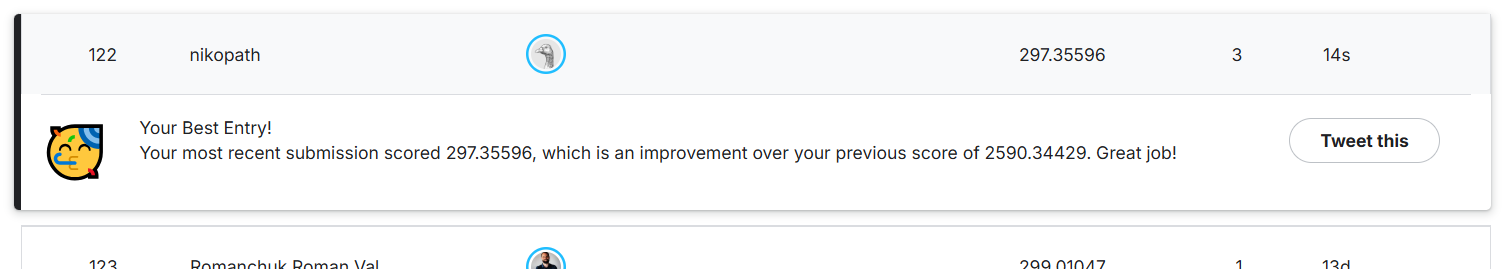